# How to read the file

The netcdf file contains:  
- Temperature profiles (36 depth levels) from the surface down to about -1000m. This is in the variable "TEMP"
- The classification result of this profile. It's an integer between 1 and 4, in the variable "LABEL"
- A patch of Sea Surface Temperature centered on the temperature profile. The patch is 13 x 13 points, so we have 6 values around the profile point. This is in the variable "SST"
- A patch of Sea Level Anomaly centered on the temperature profile. Like SST, the patch is also 13 x 13 points, so we have 6 values around the profile point. This is in the variable "SLA"
- Coordinates of each patch points are in "lat" and "lon". The grid is not regular, so each patch point has its own latitude and longitude.
- The date of the profile is in "tim" and the depth levels of the profile in "dpt".

Last, there are "n_obs" samples for each of these.


# Preamble

In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import func
from IPython.display import Image
from IPython.core.display import HTML

# Load patches

In [2]:
patch_length_lon = 6 # Half zonal length of the patch
patch_length_lat = 6 # Half meridional length of the patch

filename = ("ALLPATCHES_NX%i_NY%i.nc")%(2*patch_length_lon+1,2*patch_length_lat+1)

# Load patches:
ds = xr.open_dataset(filename)
# ds = ds.stack(patch=('latitude', 'longitude'))
# ds = ds.unstack('patch')
ds

<xarray.Dataset>
Dimensions:    (depth: 36, latitude: 13, longitude: 13, n_obs: 361)
Coordinates:
    dpt        (depth) float64 ...
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    lat        (n_obs, latitude, longitude) float64 ...
    lon        (n_obs, latitude, longitude) float64 ...
    tim        (n_obs) datetime64[ns] ...
Dimensions without coordinates: depth, n_obs
Data variables:
    SST        (n_obs, latitude, longitude) float64 ...
    SLA        (n_obs, latitude, longitude) float64 ...
    TEMP       (n_obs, depth) float64 ...
    LABEL      (n_obs) float64 ...

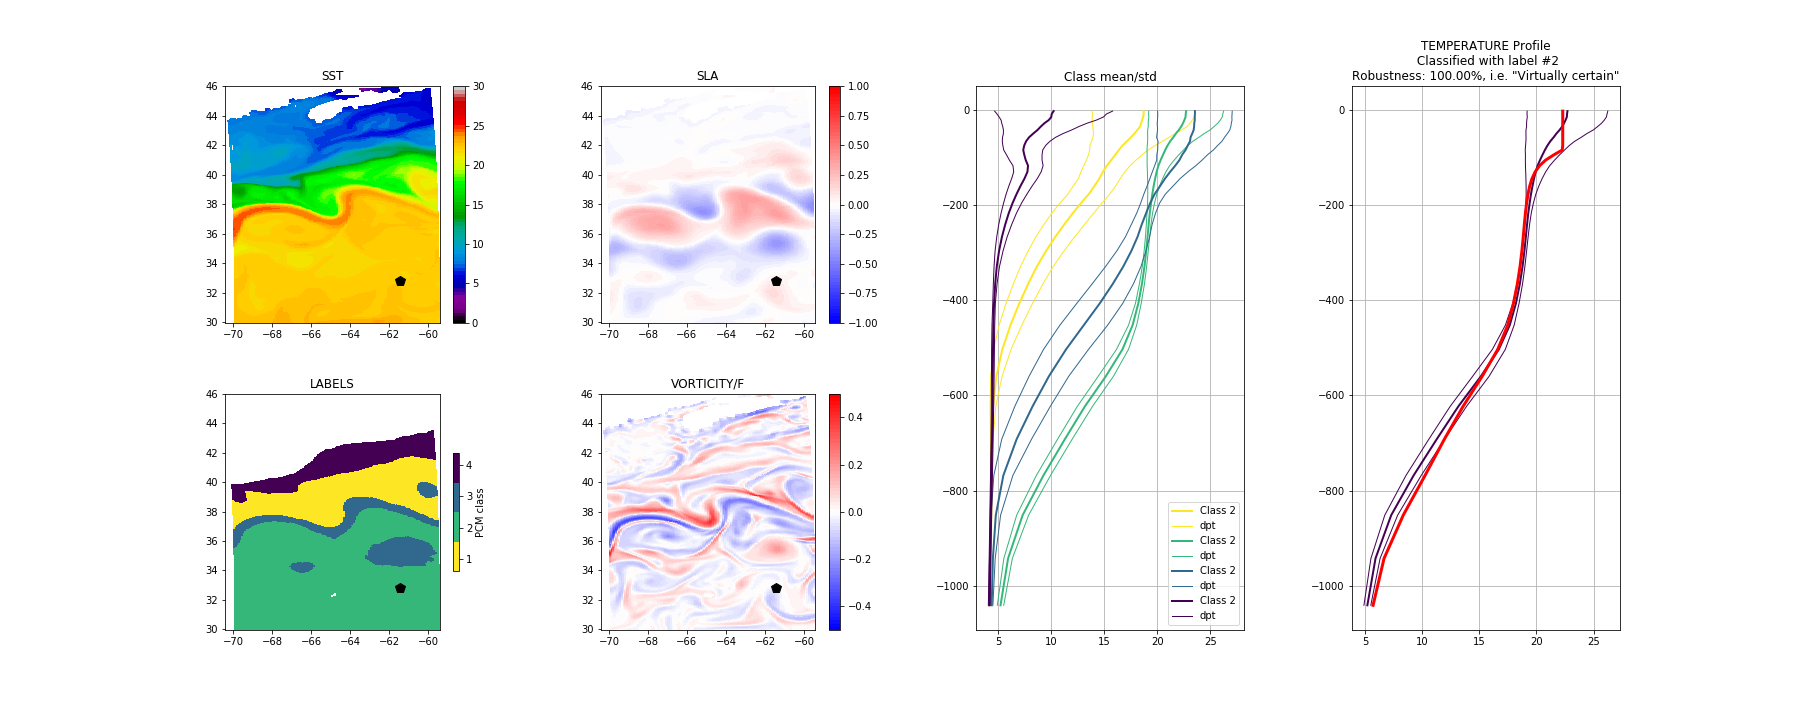

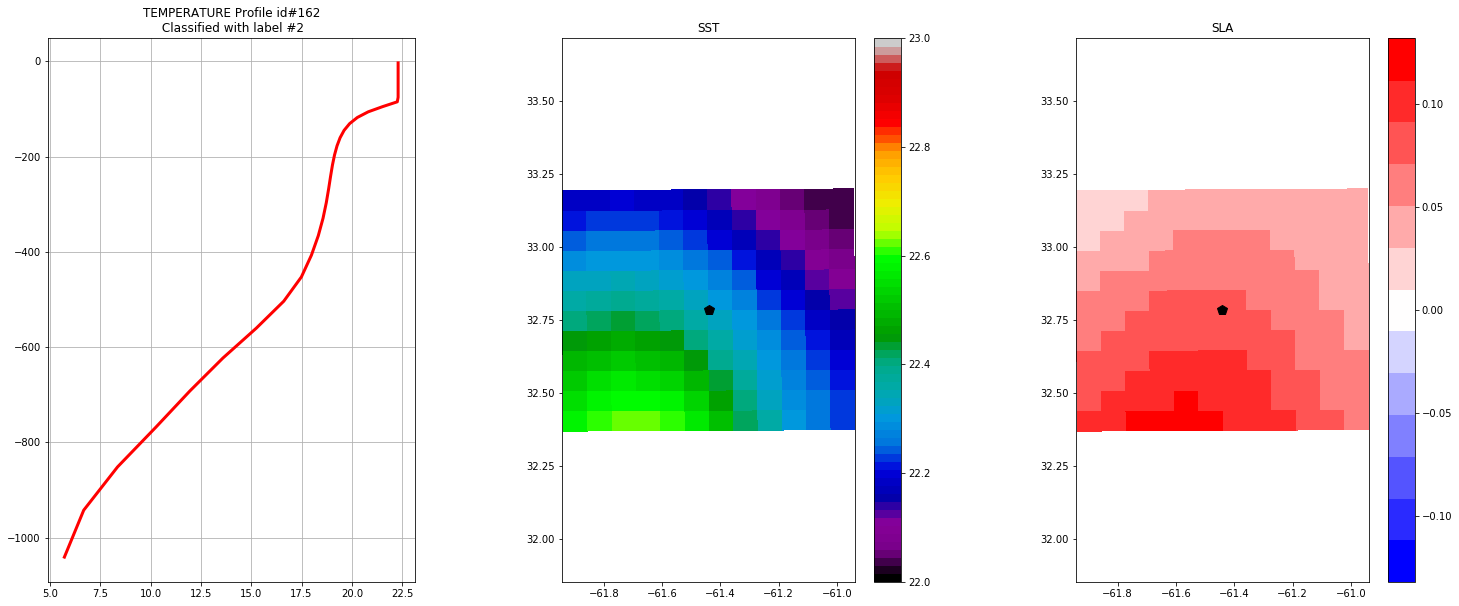

In [12]:
# Plot one observation:

# i_obs = 0
i_obs = np.random.randint(0,ds['n_obs'].max()-1,1)[0] # Because n_obs is 1-based

fig = plt.figure(figsize=(25, 10))
grid = plt.GridSpec(1, 3, wspace=0.4, hspace=0.3)

def show_loc():
    y = ds['lat'].isel(n_obs=i_obs).isel(latitude=patch_length_lat).isel(longitude=patch_length_lon)
    x = ds['lon'].isel(n_obs=i_obs).isel(latitude=patch_length_lat).isel(longitude=patch_length_lon)
    plt.plot(x, y, 'kp', markersize=10)


# Profile:
ax = plt.subplot(grid[0, 0])
# plt.plot(PCM['MU'+str(int(obs_label))],ds['dpt'].isel(time=itim), color=cmap(obs_label-1), linewidth=2)
# plt.plot(PCM['MU'+str(int(obs_label))]-PCM['SI'+str(int(obs_label))],ds['dpt'].isel(time=itim), color=cmap(obs_label-1), linewidth=1)
# plt.plot(PCM['MU'+str(int(obs_label))]+PCM['SI'+str(int(obs_label))],ds['dpt'].isel(time=itim), color=cmap(obs_label-1), linewidth=1)
plt.plot(ds['TEMP'].isel(n_obs=i_obs), ds['dpt'], color='r', linewidth=3)
ax.set_title( ("TEMPERATURE Profile id#%i\n Classified with label #%i")%(i_obs, ds['LABEL'].isel(n_obs=i_obs)) )
ax.grid('on')

# Sea Surface Temperature Map:
ax = plt.subplot(grid[0, 1])
K = 68
cmap = func.cmap_discretize(plt.cm.spectral, K)
ext = np.round([ds['SST'].isel(n_obs=i_obs).min(), ds['SST'].isel(n_obs=i_obs).max()])
plt.pcolormesh(ds['lon'].isel(n_obs=i_obs), ds['lat'].isel(n_obs=i_obs), ds['SST'].isel(n_obs=i_obs), cmap=cmap, vmin=ext[0],vmax=ext[1])
show_loc()
ax.axis('equal')
plt.colorbar()
ax.set_title('SST')

# Sea Surface Height:
ax = plt.subplot(grid[0, 2])
K = 13
cmap = func.cmap_discretize(plt.cm.bwr, K)
ext = 1.1*np.round(np.max(np.abs([ds['SLA'].isel(n_obs=i_obs).min(), ds['SLA'].isel(n_obs=i_obs).max()])),2)
plt.pcolormesh(ds['lon'].isel(n_obs=i_obs), ds['lat'].isel(n_obs=i_obs), ds['SLA'].isel(n_obs=i_obs), cmap=cmap, vmin=-ext,vmax=ext)
show_loc()
ax.axis('equal')
plt.colorbar()
ax.set_title('SLA')

# fig.show()

# Display context:
IMAGE = ("img/PATCH%03d.png")%(i_obs)
Image(filename = IMAGE)

# Create one row with temperature profile and patch data

Concatenate SST and SLA in a single row


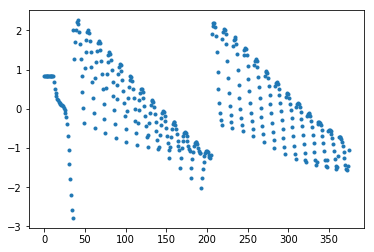

In [13]:
label = ds['LABEL'].isel(n_obs=i_obs).values[np.newaxis]
temp = ds['TEMP'].isel(n_obs=i_obs)
sla = ds['SLA'].isel(n_obs=i_obs).stack(features=('latitude','longitude'))
sst = ds['SST'].isel(n_obs=i_obs).stack(features=('latitude','longitude'))

# Possibly normalise features:
temp = (temp - np.mean(temp))/np.std(temp)
sla = (sla - np.mean(sla))/np.std(sla)
sst = (sst - np.mean(sst))/np.std(sst)

# Merge:
features = np.concatenate((sla, sst), axis=0)
# or
features = np.concatenate((label, sla, sst), axis=0)
# or
features = np.concatenate((temp, label, sla, sst), axis=0)

# Plot:
plt.plot(features,'.')